<a href="https://colab.research.google.com/github/dominique-nshimyimana/Car-State/blob/master/lstm_car_state_action_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Colab: TensorFlow and GoogleDrive [Car State-Action]

In [0]:
%tensorflow_version 2.x

In [11]:
from google.colab import drive
mounted = '/drive'
drive.mount(mounted)

Drive already mounted at /drive; to attempt to forcibly remount, call drive.mount("/drive", force_remount=True).


In [0]:
import tensorflow as tf
import numpy as np
from os import listdir
from os.path import isfile, join
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, LSTM, SimpleRNN, GRU, Dense, Lambda
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import RepeatVector
from tensorflow.keras.layers import TimeDistributed

# Prepare Data

### Data Functions

In [0]:
# Load dat from folder
# CSV form: Dataset
# Timestamp, x, y, yaw, xvel, yvel, omega, accel, brake, steering
def load_states_actions(data_dir, cutoff_beginning = 300, cutoff_end = 1000, norm=True):
  data_files = [join(data_dir, f) for f in listdir(data_dir) if isfile(join(data_dir, f)) and ".directory" not in f]

  xs_states = []
  xs_actions = []
  ys = []

  for f in data_files:
      print(f)
      data = np.loadtxt(f, delimiter=', ', skiprows=1, dtype=np.float32)[cutoff_beginning:-cutoff_end, :]
      x_states = [data[i, 1:-3] for i in range(len(data))]
      x_actions = [data[i, -3:] for i in range(len(data))]
      y = x_states[1:]
      x_states, x_actions = x_states[:-1], x_actions[:-1]
      xs_states += x_states
      xs_actions += x_actions

  xs_states = np.vstack(xs_states)
  xs_actions = np.vstack(xs_actions)

  scaler = MinMaxScaler()
  xs_states = scaler.fit_transform(xs_states)
  xs_actions = scaler.fit_transform(xs_actions)
  return xs_states, xs_actions

# convert an array of values into a dataset matrix
# State(s) at a given time t (or time series until t) and Y is the state at the next time (t + 1).
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		dataX.append(np.squeeze(dataset[i:(i+look_back)])) #dataset[i:(i+look_back), 0]
		dataY.append(dataset[i + look_back]) #dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)

def takeSlice(arr, fr, to, name):
    
    result = arr[:,fr:to,:]
    print(name + ": start at " + str(fr) + " - shape: " + str(result.shape))
    return result

### Load and Preapre

In [14]:
# Load Data
data_dir = "/drive/My Drive/neuronyte_logging"
xs_states, xs_actions = load_states_actions(data_dir=data_dir)

/drive/My Drive/neuronyte_logging/NeuroNyte_1585748620.316643
/drive/My Drive/neuronyte_logging/NeuroNyte_1585745385.311904


In [15]:
# Split data
x_states_train, x_states_test, x_actions_train, x_actions_test = train_test_split(xs_states, xs_actions, test_size=0.10)

# How many steps/state in back from t and # How many steps/state in future/forward from t
look_back = 1
look_forward = 1
totalLength = 12000
trainLength = 11800
shift = 7

 
mydata = np.copy(x_states_test[1:12001:1]).reshape(1, 12000,6)
print('mydata: ', mydata.shape)

mydata:  (1, 12000, 6)


# Training (Model)

In [16]:
out = 6 # {2,6}
x = takeSlice(mydata,0,trainLength,'x') #von 0 a trainLength
y = takeSlice(mydata,shift,shift+trainLength,'y') #von shift a trainLength+shift
data = mydata
print(x.shape, y.shape)

model = Sequential()
model.add(LSTM(200,return_sequences=True,input_shape=(None,out))) #input takes any steps, two features (var1 and var2)
model.add(LSTM(140,return_sequences=True))
model.add(LSTM(100,return_sequences=True))
model.add(LSTM(100,return_sequences=True))
model.add(LSTM(70,return_sequences=True))
model.add(LSTM(70,return_sequences=True))
model.add(LSTM(out,return_sequences=True)) #output keeps the steps and has two features
model.add(Lambda(lambda x: x*1.3))

from keras.callbacks import EarlyStopping
stop = tf.keras.callbacks.EarlyStopping(monitor='loss',min_delta=0.000000000001,patience=30)
rates = [0.001,0.0001,0.00001]
for rate in rates:
    #print('training with lr = ' + str(rate))
    model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(lr=rate))
    model.fit(x,y,epochs=20,callbacks=[stop],verbose=0)
print('Trained!')

x: start at 0 - shape: (1, 11800, 6)
y: start at 7 - shape: (1, 11800, 6)
(1, 11800, 6) (1, 11800, 6)
Trained!


# Testing (Model)

In [17]:
#the model for predictions - copies the other model, but uses `return_sequences=False` and `stateful=True`
#the change is just to allow predicting step by step and using the predictions as new steps. 
newModel = Sequential()
newModel.add(LSTM(200,return_sequences=True,stateful=True,batch_input_shape=(1,None,out)))
newModel.add(LSTM(140,return_sequences=True,stateful=True))
newModel.add(LSTM(100,return_sequences=True,stateful=True))
newModel.add(LSTM(100,return_sequences=True,stateful=True))
newModel.add(LSTM(70,return_sequences=True,stateful=True))
newModel.add(LSTM(70,return_sequences=True,stateful=True))
newModel.add(LSTM(out,return_sequences=False,stateful=True))
newModel.add(Lambda(lambda x: x*1.3))

newModel.set_weights(model.get_weights())
newModel.reset_states()

lastSteps = np.empty((1,totalLength-trainLength,out)) #includes a shift at the beginning to cover the gap 
lastSteps[:,:shift] = x[:,-shift:] #the initial shift steps are filled with x training data 


newModel.predict(x[:,:-shift,:]).reshape(1,1,out) #just to adjust states, predict with x without the last shift elements

rangeLen = totalLength-trainLength-shift
print('rangeLen: ', rangeLen)
for i in range(rangeLen):
    lastSteps[:,i+shift] = newModel.predict(lastSteps[:,i:i+1,:]).reshape(1,1,out)
print(lastSteps.shape)
forecastFromSelf = lastSteps[:,shift:,:]

#predicting from test/future data:
newModel.reset_states()
newModel.predict(x) #just to set the states and get used to the sequence

newSteps = []
#true data for forecasting:
xForecast = takeSlice(data,trainLength,-shift,'xForecast') #de 800 a 1192?
trueForecast = takeSlice(data,shift+trainLength,None,'trueForecast') #de 807 a 1199

for i in range(xForecast.shape[1]):
    newSteps.append(newModel.predict(xForecast[:,i:i+1,:]))
forecastFromInput = np.asarray(newSteps).reshape(1,xForecast.shape[1],out)
print('Prediction done!')

rangeLen:  193
(1, 200, 6)
xForecast: start at 11800 - shape: (1, 193, 6)
trueForecast: start at 11807 - shape: (1, 193, 6)
Prediction done!


# Visualization of result

trueForecast:  (1, 193, 6)
forecastFromSelf:  (1, 193, 6)
forecastFromInput:  (1, 193, 6)



black line: true values
gold line: predicted values
(1, 193, 6) (1, 193, 2) (193, 2)


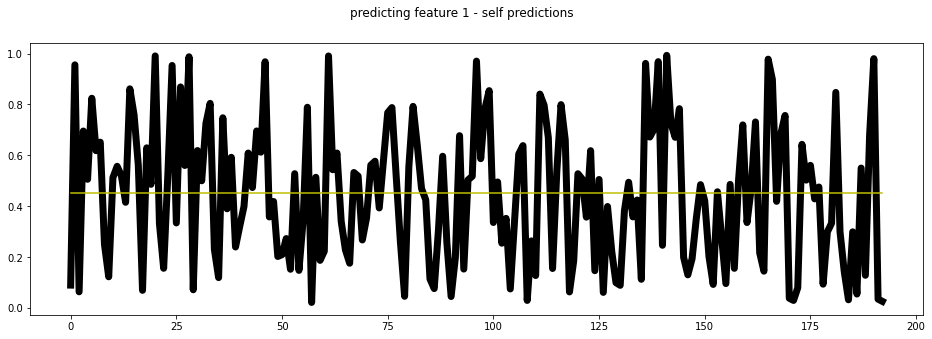

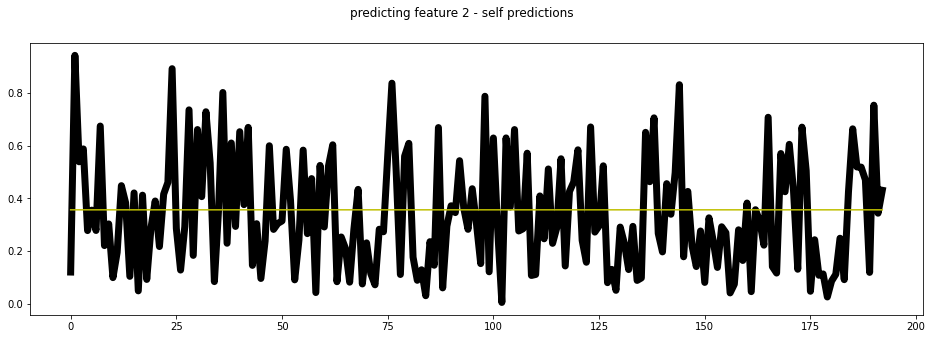

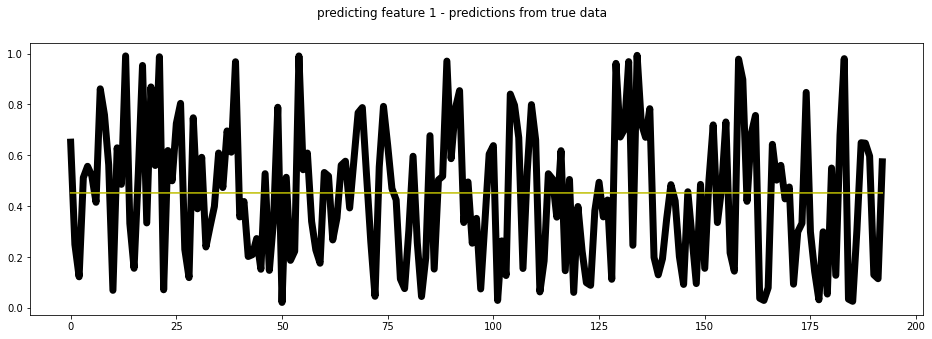

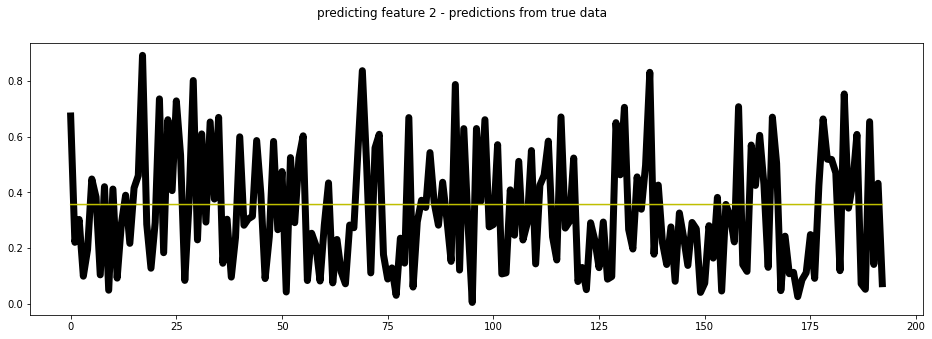

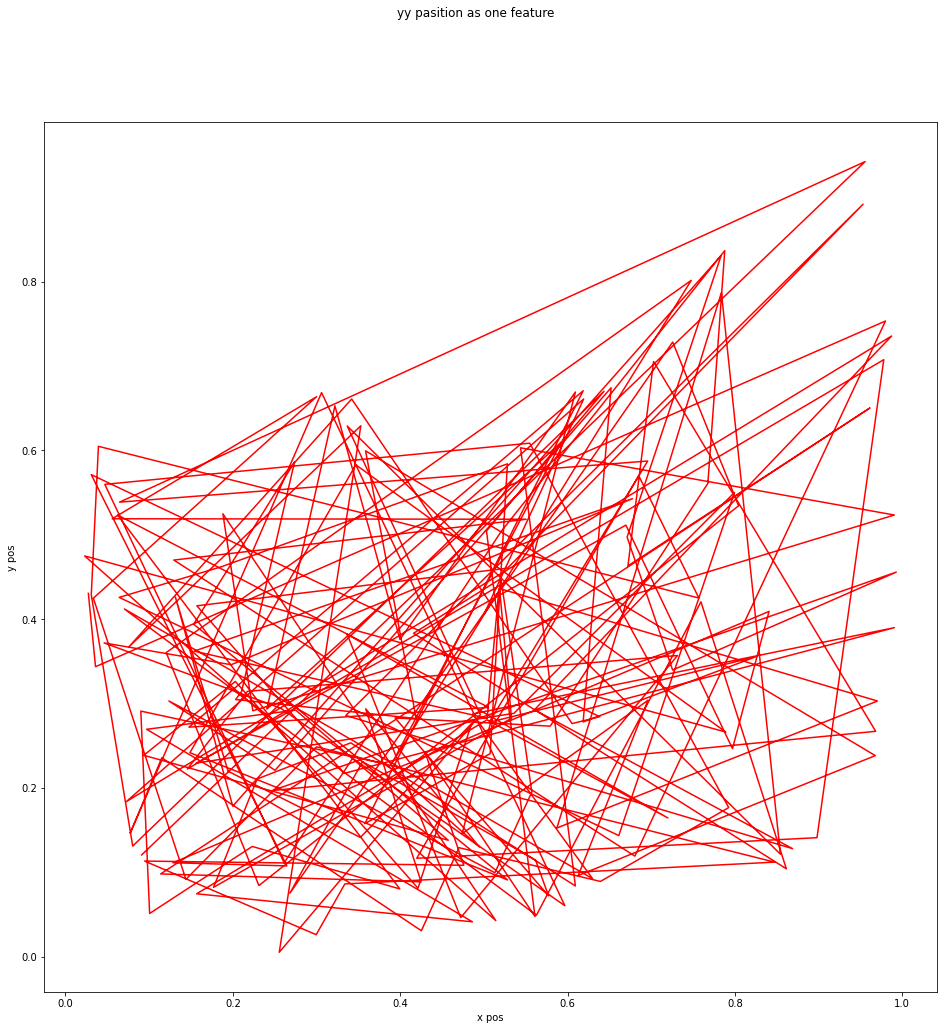

In [20]:
import matplotlib.pyplot as plt

print('trueForecast: ', trueForecast.shape)
print('forecastFromSelf: ', forecastFromSelf.shape)
print('forecastFromInput: ', forecastFromInput.shape)
print('\n\n\nblack line: true values')
print('gold line: predicted values')

print(xForecast.shape, xForecast[:,:,0:2].shape, np.squeeze(xForecast[:,:,0:2], axis=0).shape)

#self forecast
fig,ax = plt.subplots(1,1,figsize=(16,5))
ax.plot(xForecast[0,:,0], linewidth=7,color='k') #this uses xForecast because it starts exactly where x ends
ax.plot(forecastFromSelf[0,:,0],color='y')
plt.suptitle("predicting feature 1 - self predictions")
plt.show()

fig,ax = plt.subplots(1,1,figsize=(16,5))
ax.plot(xForecast[0,:,1],linewidth=7,color='k') #this uses xForecast because it starts exactly where x ends
ax.plot(forecastFromSelf[0,:,1],color='y')
plt.suptitle("predicting feature 2 - self predictions")
plt.show()


#forecast from test/future data:
fig,ax = plt.subplots(1,1,figsize=(16,5))
ax.plot(trueForecast[0,:,0], linewidth=7,color='k')
ax.plot(forecastFromInput[0,:,0],color='y')
plt.suptitle("predicting feature 1 - predictions from true data")
plt.show()

fig,ax = plt.subplots(1,1,figsize=(16,5))
ax.plot(trueForecast[0,:,1],linewidth=7,color='k')
ax.plot(forecastFromInput[0,:,1],color='y')
plt.suptitle("predicting feature 2 - predictions from true data")
plt.show()

#######################################
###########################################

xs_states_inpt = np.squeeze(xForecast[:,:,0:2], axis=0)
xs_states_pred = np.squeeze(forecastFromSelf[:,:,0:2], axis=0)

fig,ax = plt.subplots(1,1,figsize=(16,16))
ax.plot(*zip(*xs_states_inpt), 'r')
ax.plot(*zip(*xs_states_pred),'b')
plt.xlabel('x pos')
plt.ylabel('y pos')
plt.suptitle("yy pasition as one feature")
plt.show()

## Docs


1.   https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/
2.   https://stackabuse.com/solving-sequence-problems-with-lstm-in-keras/
3.   https://towardsdatascience.com/reinforcement-learning-w-keras-openai-dqns-1eed3a5338c
4.   https://keras.io/guides/functional_api/,  https://keras.io/api/models/model/ and https://keras.io/api/layers/recurrent_layers/
5.   Not easy to continue: https://github.com/tensorflow/tensorflow/issues/38064
